In [ ]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
data = pd.read_excel('impute_data.xlsx')
print(data.shape)
data.head()

(1339, 96)


,节点0功率,节点1功率,节点2功率,节点3功率,节点4功率,节点5功率,节点6功率,节点7功率,节点8功率,节点9功率,...,节点86功率,节点87功率,节点88功率,节点89功率,节点90功率,节点91功率,节点92功率,节点93功率,节点94功率,节点95功率
2018-01-01,244033.7682,232720.6402,231685.6891,227581.3317,233482.4269,224464.7554,223881.3222,221522.7156,228138.5805,220047.4568,...,234535.8695,232184.9459,238362.0286,228433.3587,224915.6451,222615.9423,225228.9648,213662.3933,209709.2317,205839.6378
2018-01-02,207655.1990,200673.8192,199179.7267,199204.4665,213530.4627,192532.5988,188883.3155,188022.8548,194513.1024,187211.6824,...,269290.6416,267889.5761,271585.0201,263482.9724,260430.3031,268515.5360,260295.6097,270992.1341,250472.5514,244224.2000
2018-01-03,248503.4810,236440.6647,233974.9909,232474.0213,235308.6404,231016.0498,230976.8460,226422.5222,233703.3045,227215.1967,...,274789.8773,274039.4817,280565.2247,289556.1424,266657.4444,264818.1174,268641.5741,255383.4266,253372.3768,247607.8786
2018-01-04,253310.1506,244545.2255,239774.3340,242000.7265,245132.8146,236083.3085,236025.2417,233812.6096,242392.4277,229510.9984,...,271083.3414,269644.6551,278659.1120,268758.0021,264407.4489,263243.3501,266465.7950,255016.3169,252476.5852,246234.4829
2018-01-05,251749.1014,243126.3908,239751.1917,238086.1316,242231.9352,234582.4407,234513.2381,231791.2725,236081.0479,227392.3428,...,276483.8019,281264.4793,283348.3320,272798.8725,271016.2719,266879.9107,271510.8157,257809.0623,253594.7963,252019.4440


为方便观察趋势,此时将每天的均值功率作为一天的功率量,画出所有天数的功率量的图

In [3]:
index_list = data.index.tolist()
holiday_list = [datetime.datetime(2019,1,1),datetime.datetime(2019,2,22),datetime.datetime(2020,1,1),
                datetime.datetime(2020,2,8),datetime.datetime(2021,1,1),datetime.datetime(2021,2,26)]
holiday_index_list = [index_list.index(item) for item in holiday_list] 


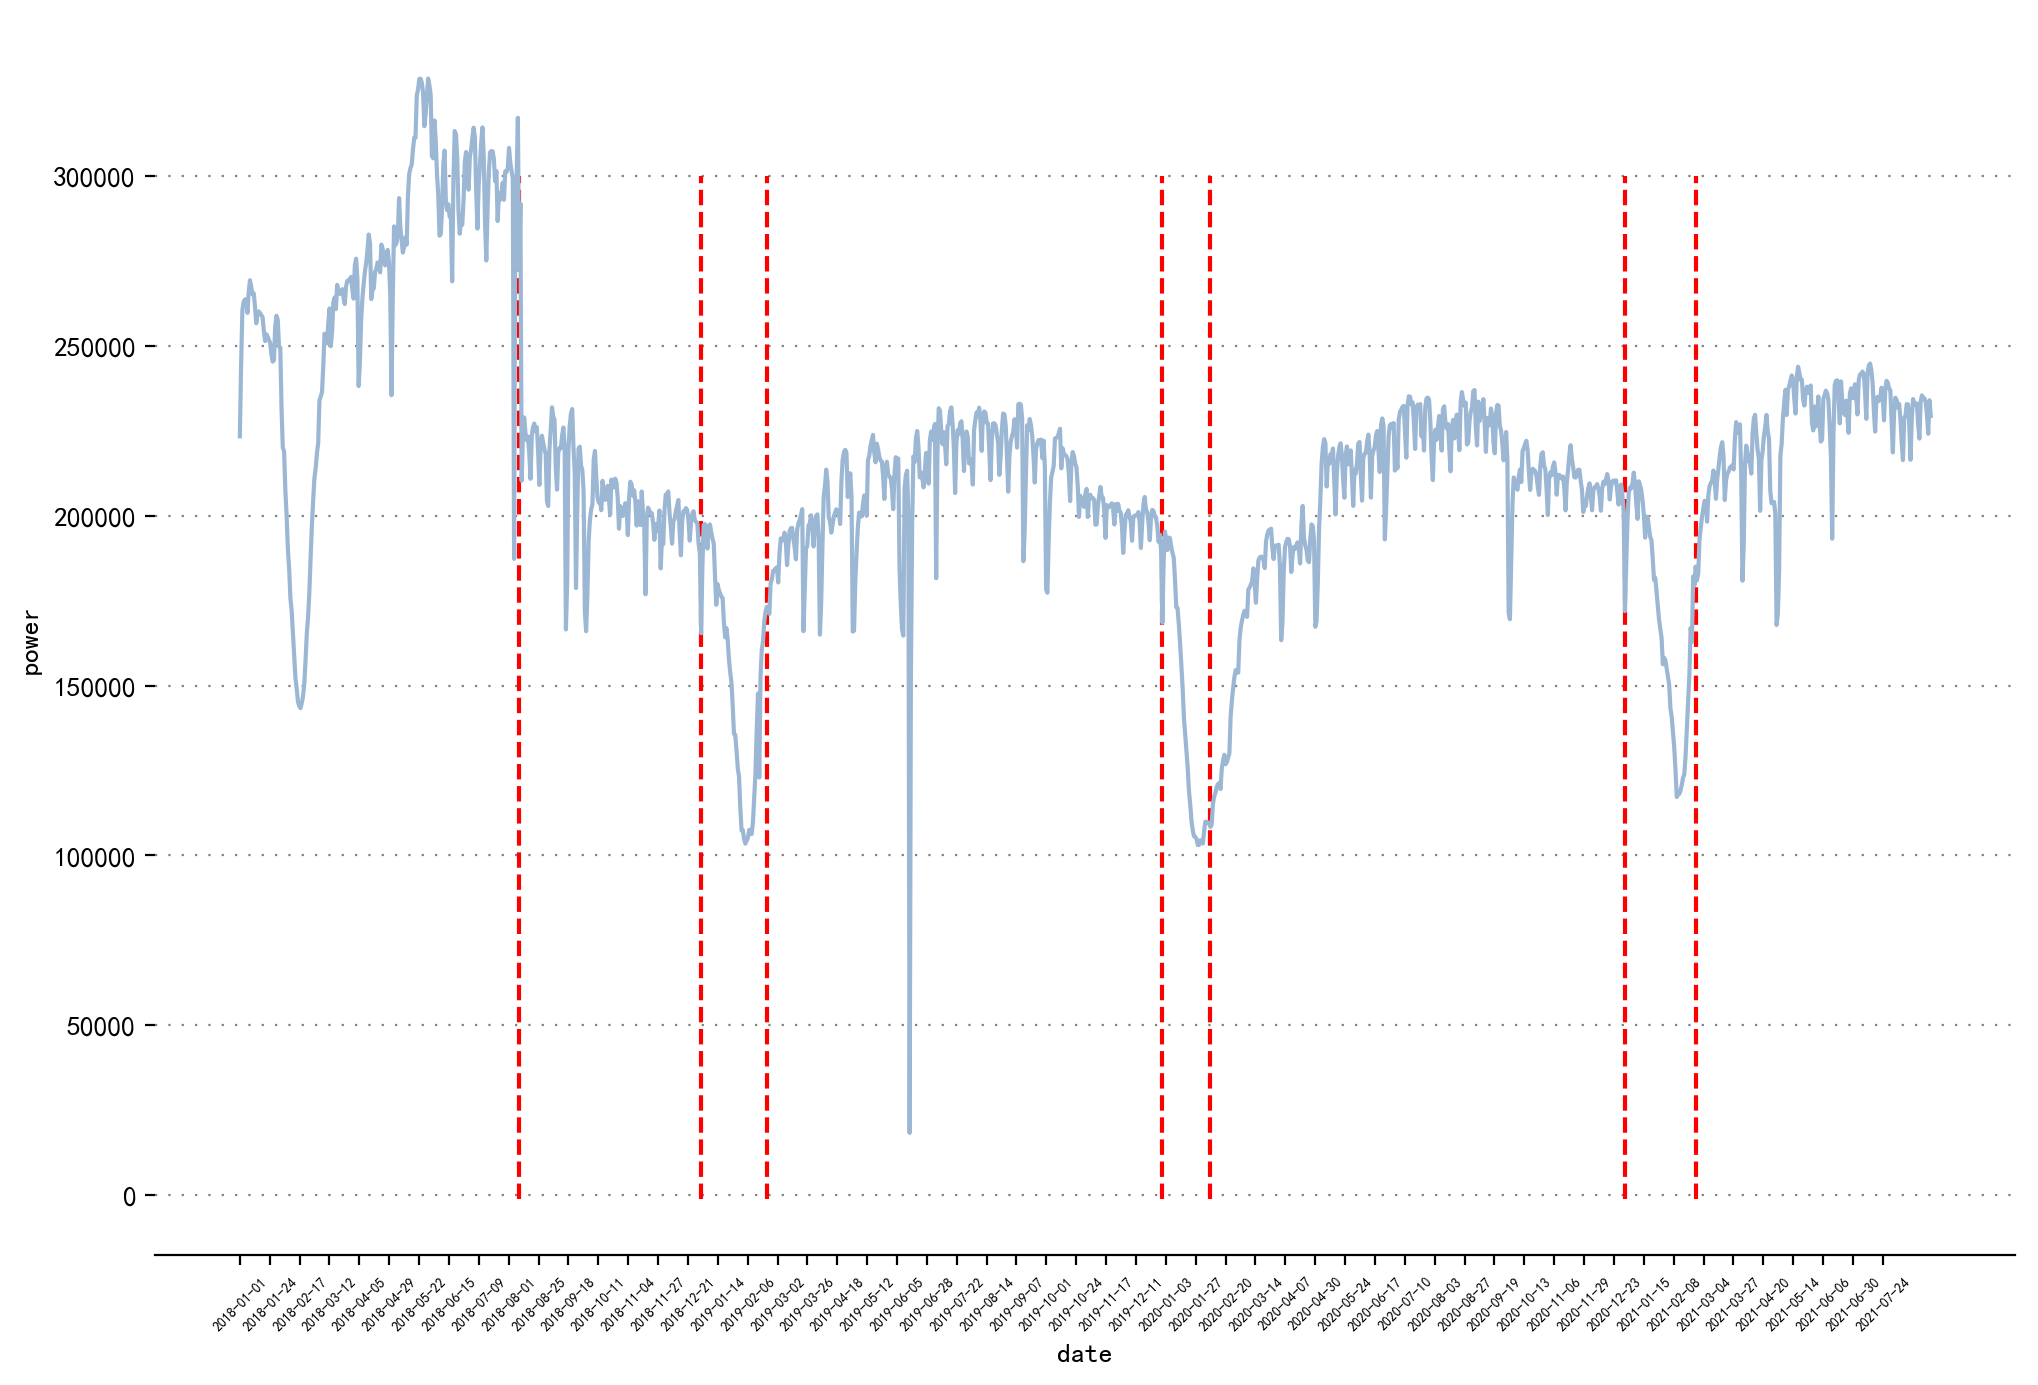

In [4]:
data_val = data.values
mean_list = np.mean(data_val,axis=1)
data['平均功率'] = mean_list
x = np.arange(data.shape[0])


plt.figure(figsize=(12,8),dpi=200)
ax = plt.subplot()
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))

ax.plot(x, mean_list, 'b', label='y1',color='#9bb7d4')

for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)

xtick_list = np.linspace(0,1300,56).tolist()
xlabel_list = [data.index[int(xtick_list[i])].date() for i in range(56)]

for line in holiday_index_list:
    plt.vlines(x=line,ymin=-1000,ymax=300000,colors='r',linestyles='dashed')
    
plt.vlines(x=index_list.index(datetime.datetime(2018,8,10)),ymin=-1000,ymax=300000,colors='r',linestyles='dashed')

plt.xticks(xtick_list,xlabel_list,rotation=45,fontsize=5)    
plt.xlabel('date')
plt.ylabel('power')
plt.show()


通过观测可以发现,每年的元旦到元宵节期间电力载荷都会出现明显下降的现象,为此不能简单将其认为是异常值,而需要考虑到节假日的因素

因此可以考虑将这段时间的数据进行初步剔除之后,对正常日期点的数据进行异常值处理

通过观察可以发现,在2018年8月中旬之前明显出现超出后面的情况,考虑到之前的数据一方面比较陈旧、另一方面出现异常抖动,可以考虑在后续的过程中

删除2018年8月中旬之前的载荷量信息,同时关注到在某些时刻的载荷量信息会出现明显的低值情况,明显超出$3\sigma$的异常点

In [5]:
bound_list = [datetime.datetime(2018,8,15),datetime.datetime(2019,1,2),datetime.datetime(2019,2,22),datetime.datetime(2020,1,2),
                datetime.datetime(2020,2,8),datetime.datetime(2021,1,2),datetime.datetime(2021,2,26),datetime.datetime(2022,1,2)]

handle_data = pd.DataFrame(columns=data.columns)
for i in range(int(len(bound_list)/2)):
    list1 = np.array(data.index > bound_list[2*i])
    list2 = np.array(data.index < bound_list[2*i+1])
    tol_list = list1 & list2
    handle_data = pd.concat([handle_data, data[tol_list]])
print(handle_data.shape)
handle_data2 = handle_data.copy()
handle_data.head()


(966, 97)


,节点0功率,节点1功率,节点2功率,节点3功率,节点4功率,节点5功率,节点6功率,节点7功率,节点8功率,节点9功率,...,节点87功率,节点88功率,节点89功率,节点90功率,节点91功率,节点92功率,节点93功率,节点94功率,节点95功率,平均功率
2018-08-16,212451.4766,201595.3959,198876.3686,198704.7529,210562.3774,198186.0021,197058.0793,194108.7134,208834.7757,195530.8807,...,198726.1835,215298.8510,198978.9039,199475.0657,199383.0466,235528.3905,198070.0293,197975.8801,195254.5568,222253.075403
2018-08-17,210766.8095,199296.5316,199141.1428,202207.4826,210759.0891,196174.6793,198685.9951,200715.5654,207056.0122,198877.0114,...,201469.1915,217147.2767,201085.9431,201927.0284,201652.9455,214586.1288,202268.6069,198494.8511,198994.2490,223346.411292
2018-08-18,210613.4869,203062.7813,200479.9746,197965.0285,209092.4548,199118.3014,194943.8115,199718.4926,211602.5007,200740.1886,...,200564.8328,215276.0678,199236.5761,198257.8237,196748.9894,210207.9812,201029.2815,201156.8849,194964.0193,218449.895951
2018-08-19,212757.2511,199543.6382,197501.6593,200804.4088,208964.6938,195966.0374,196393.8541,197498.2548,206366.8840,191948.4139,...,196043.4149,206035.0892,198259.2495,196921.1659,194766.2850,208608.9284,195080.1897,195248.2238,191834.7059,210888.285421
2018-08-20,204752.5205,193591.6919,198174.9856,195901.7735,206143.7177,196580.9113,193168.5550,194902.8083,205326.3074,193219.9387,...,200637.7747,215193.9261,198215.4020,199868.5427,198628.3280,211884.5114,197327.2822,200000.8831,199414.7702,223449.228417


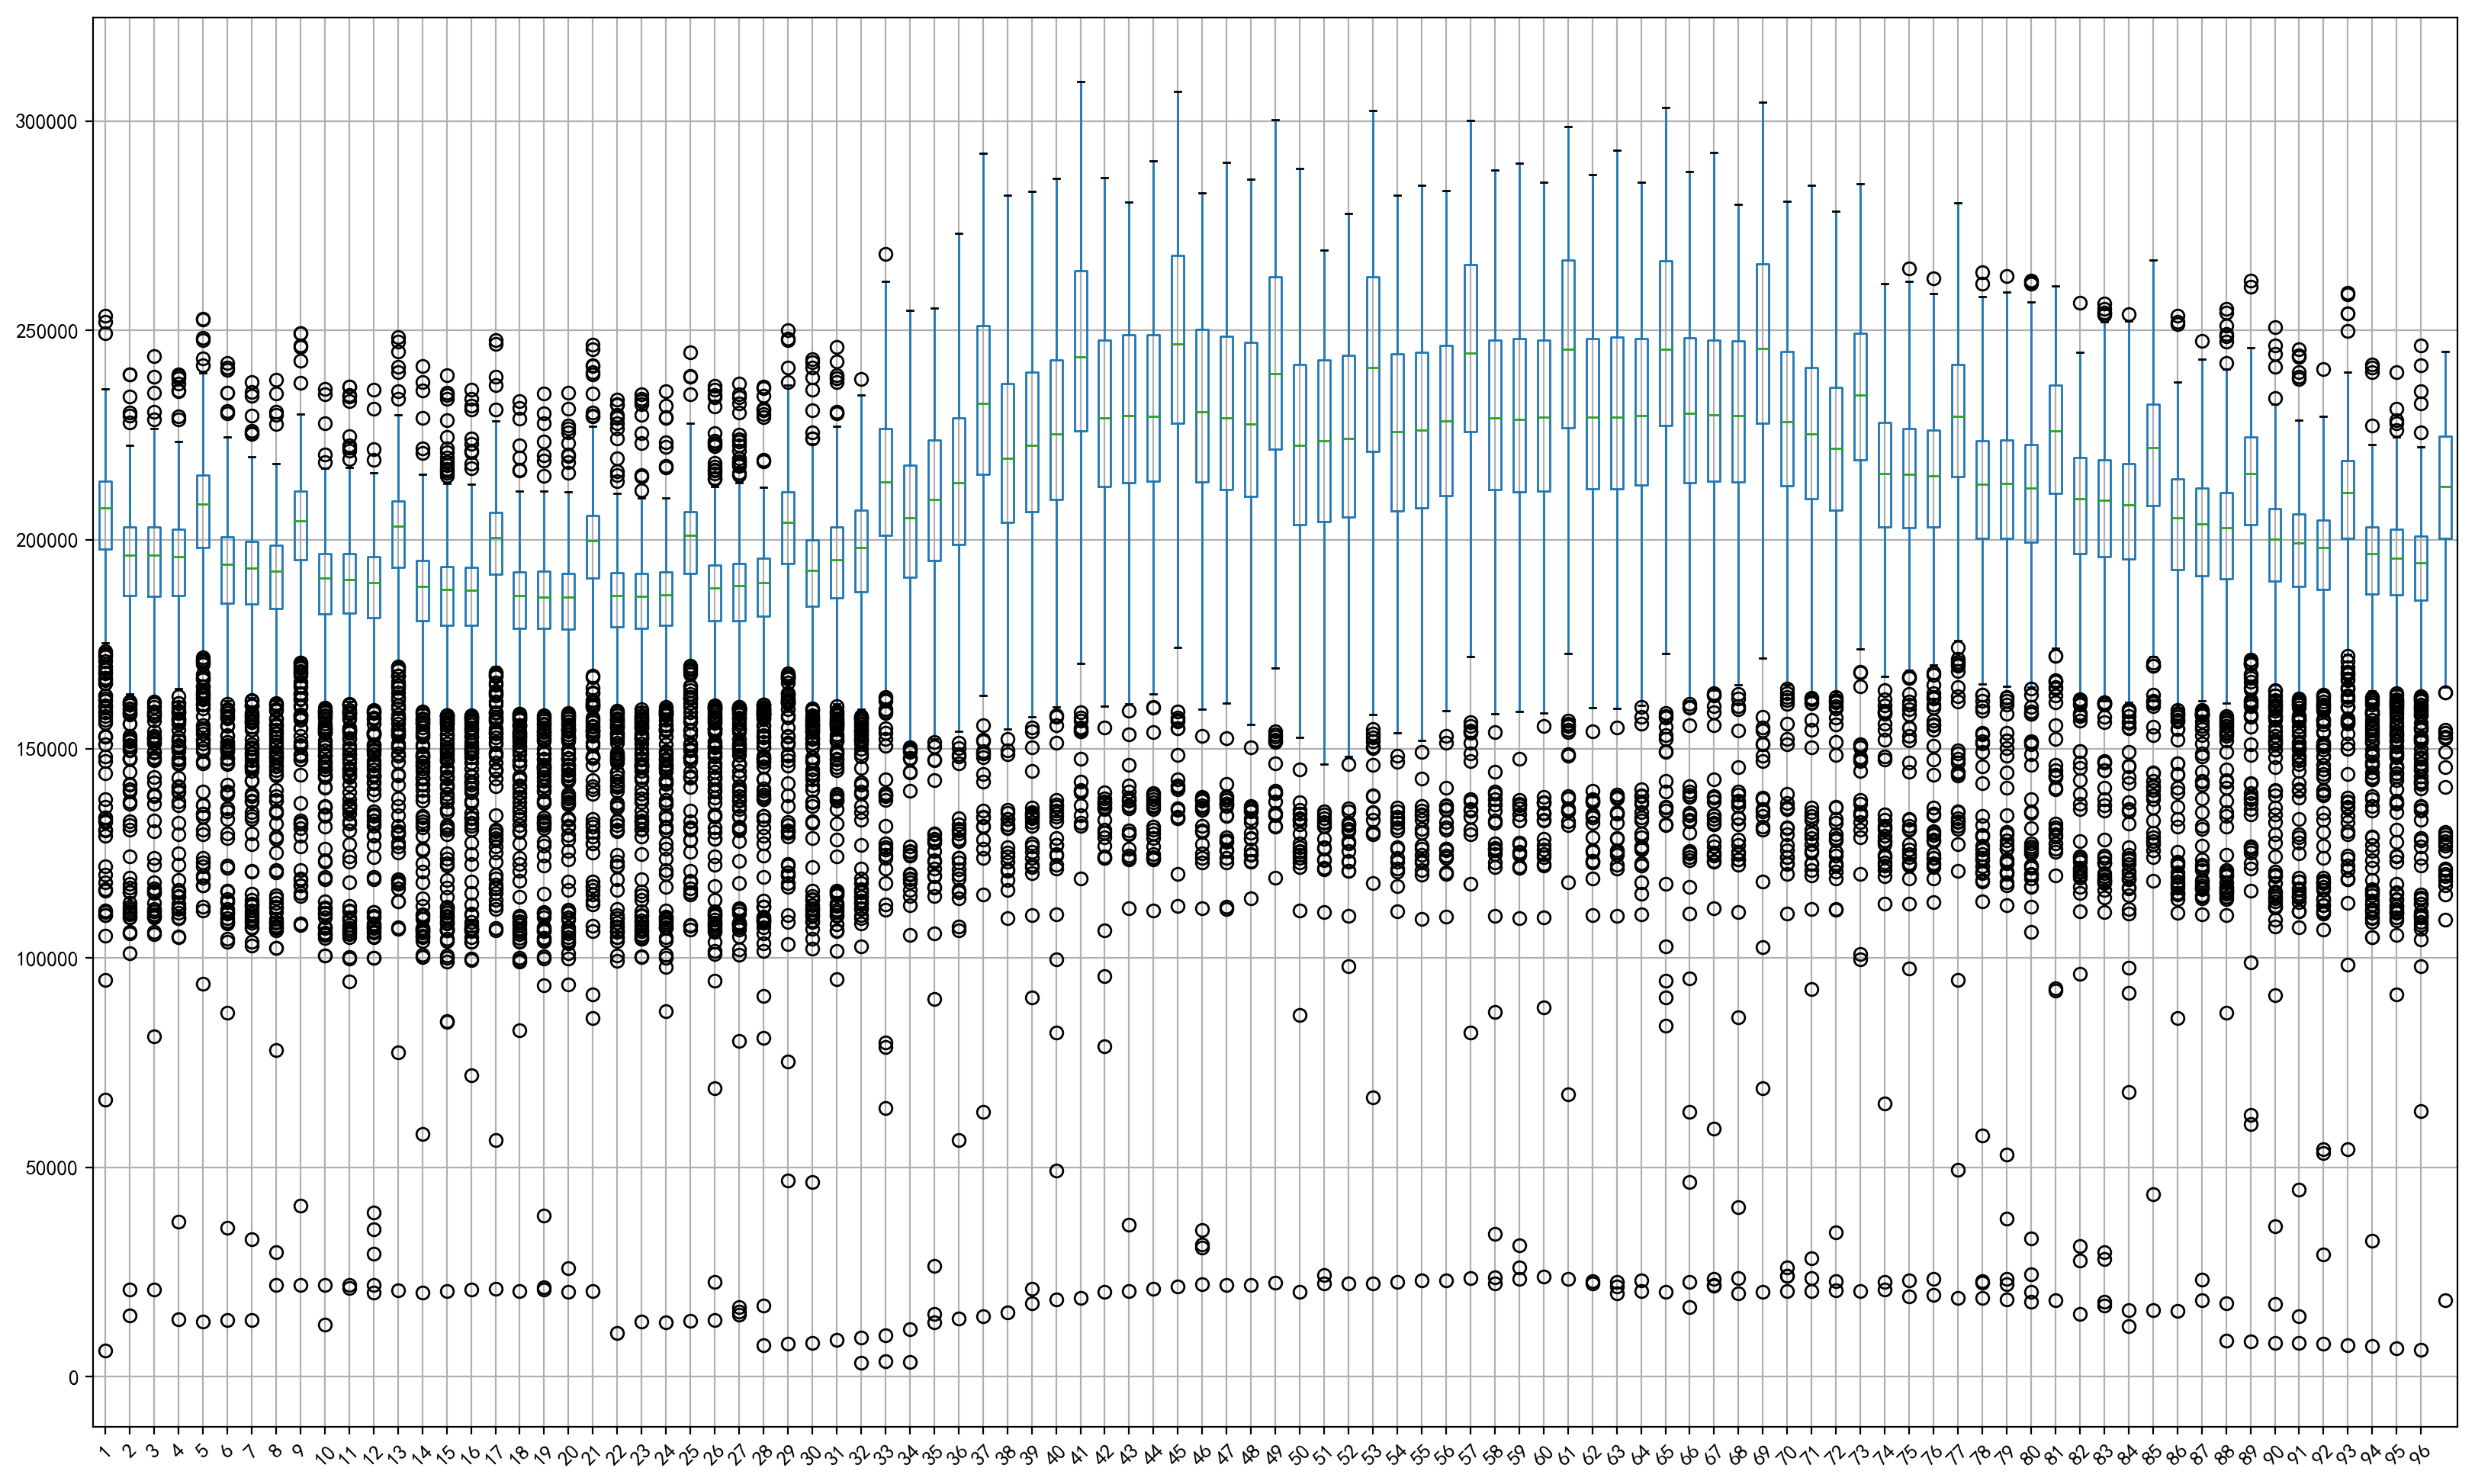

In [6]:
plt.figure(figsize=(20,12),dpi=200)

handle_data.boxplot()
xtick_list = range(1,97)
xlabel_list = range(1,97)

plt.xticks(xtick_list,xlabel_list,rotation=45,fontsize=10)    
plt.show()

可以观测到异常值是非常多的,这里使用hampel filter进行异常值过滤替换,选取

In [7]:
def hampel(X,k):
    length = X.shape[0] - 1
    nsigma = 3
    iLo = np.array([i - k for i in range(0, length + 1)])
    iHi = np.array([i + k for i in range(0, length + 1)])
    iLo[iLo < 0] = 0
    iHi[iHi > length] = length
    xmad = []
    xmedian = []
    for i in range(length + 1):
        w = X[iLo[i]:iHi[i] + 1]
        medj = np.median(w)
        mad = np.median(np.abs(w - medj))
        xmad.append(mad)
        xmedian.append(medj)
    xmad = np.array(xmad)
    xmedian = np.array(xmedian)
    scale = 1.4826  # 缩放
    xsigma = scale * xmad
    xi = ~(np.abs(X - xmedian) <= nsigma * xsigma)  # 找出离群点（即超过nsigma个标准差）
 
    # 将离群点替换为中为数值
    xf = X.copy()
    xf[xi] = xmedian[xi]
    return xf

可以观察到,针对某一特定时间点的数据波动较为明显,可视为异常点,通过hampel滤波来处理这些异常值

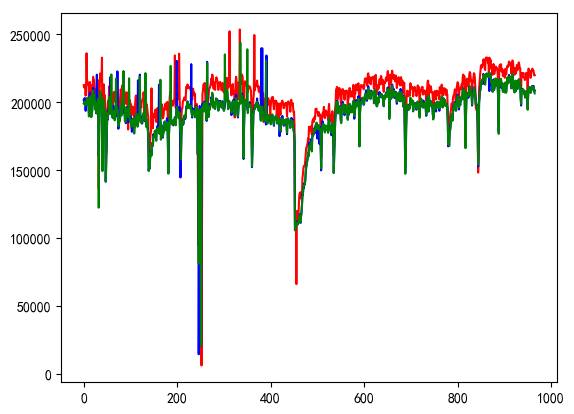

In [8]:
x1 = handle_data.iloc[:,0].values
x2 = handle_data.iloc[:,1].values
x3 = handle_data.iloc[:,2].values

plt.plot(x1,'r-')
plt.plot(x2,'b-')
plt.plot(x3,'g-')
plt.show()

In [9]:
for i in range(96):
    values = handle_data.iloc[:,i].values
    # 为hamble滤波器设置为周围5个点
    handled_x = hampel(values, 5)
    handle_data.iloc[:,i] = handled_x
handle_data.head()

exc_handled_data = handle_data.copy()

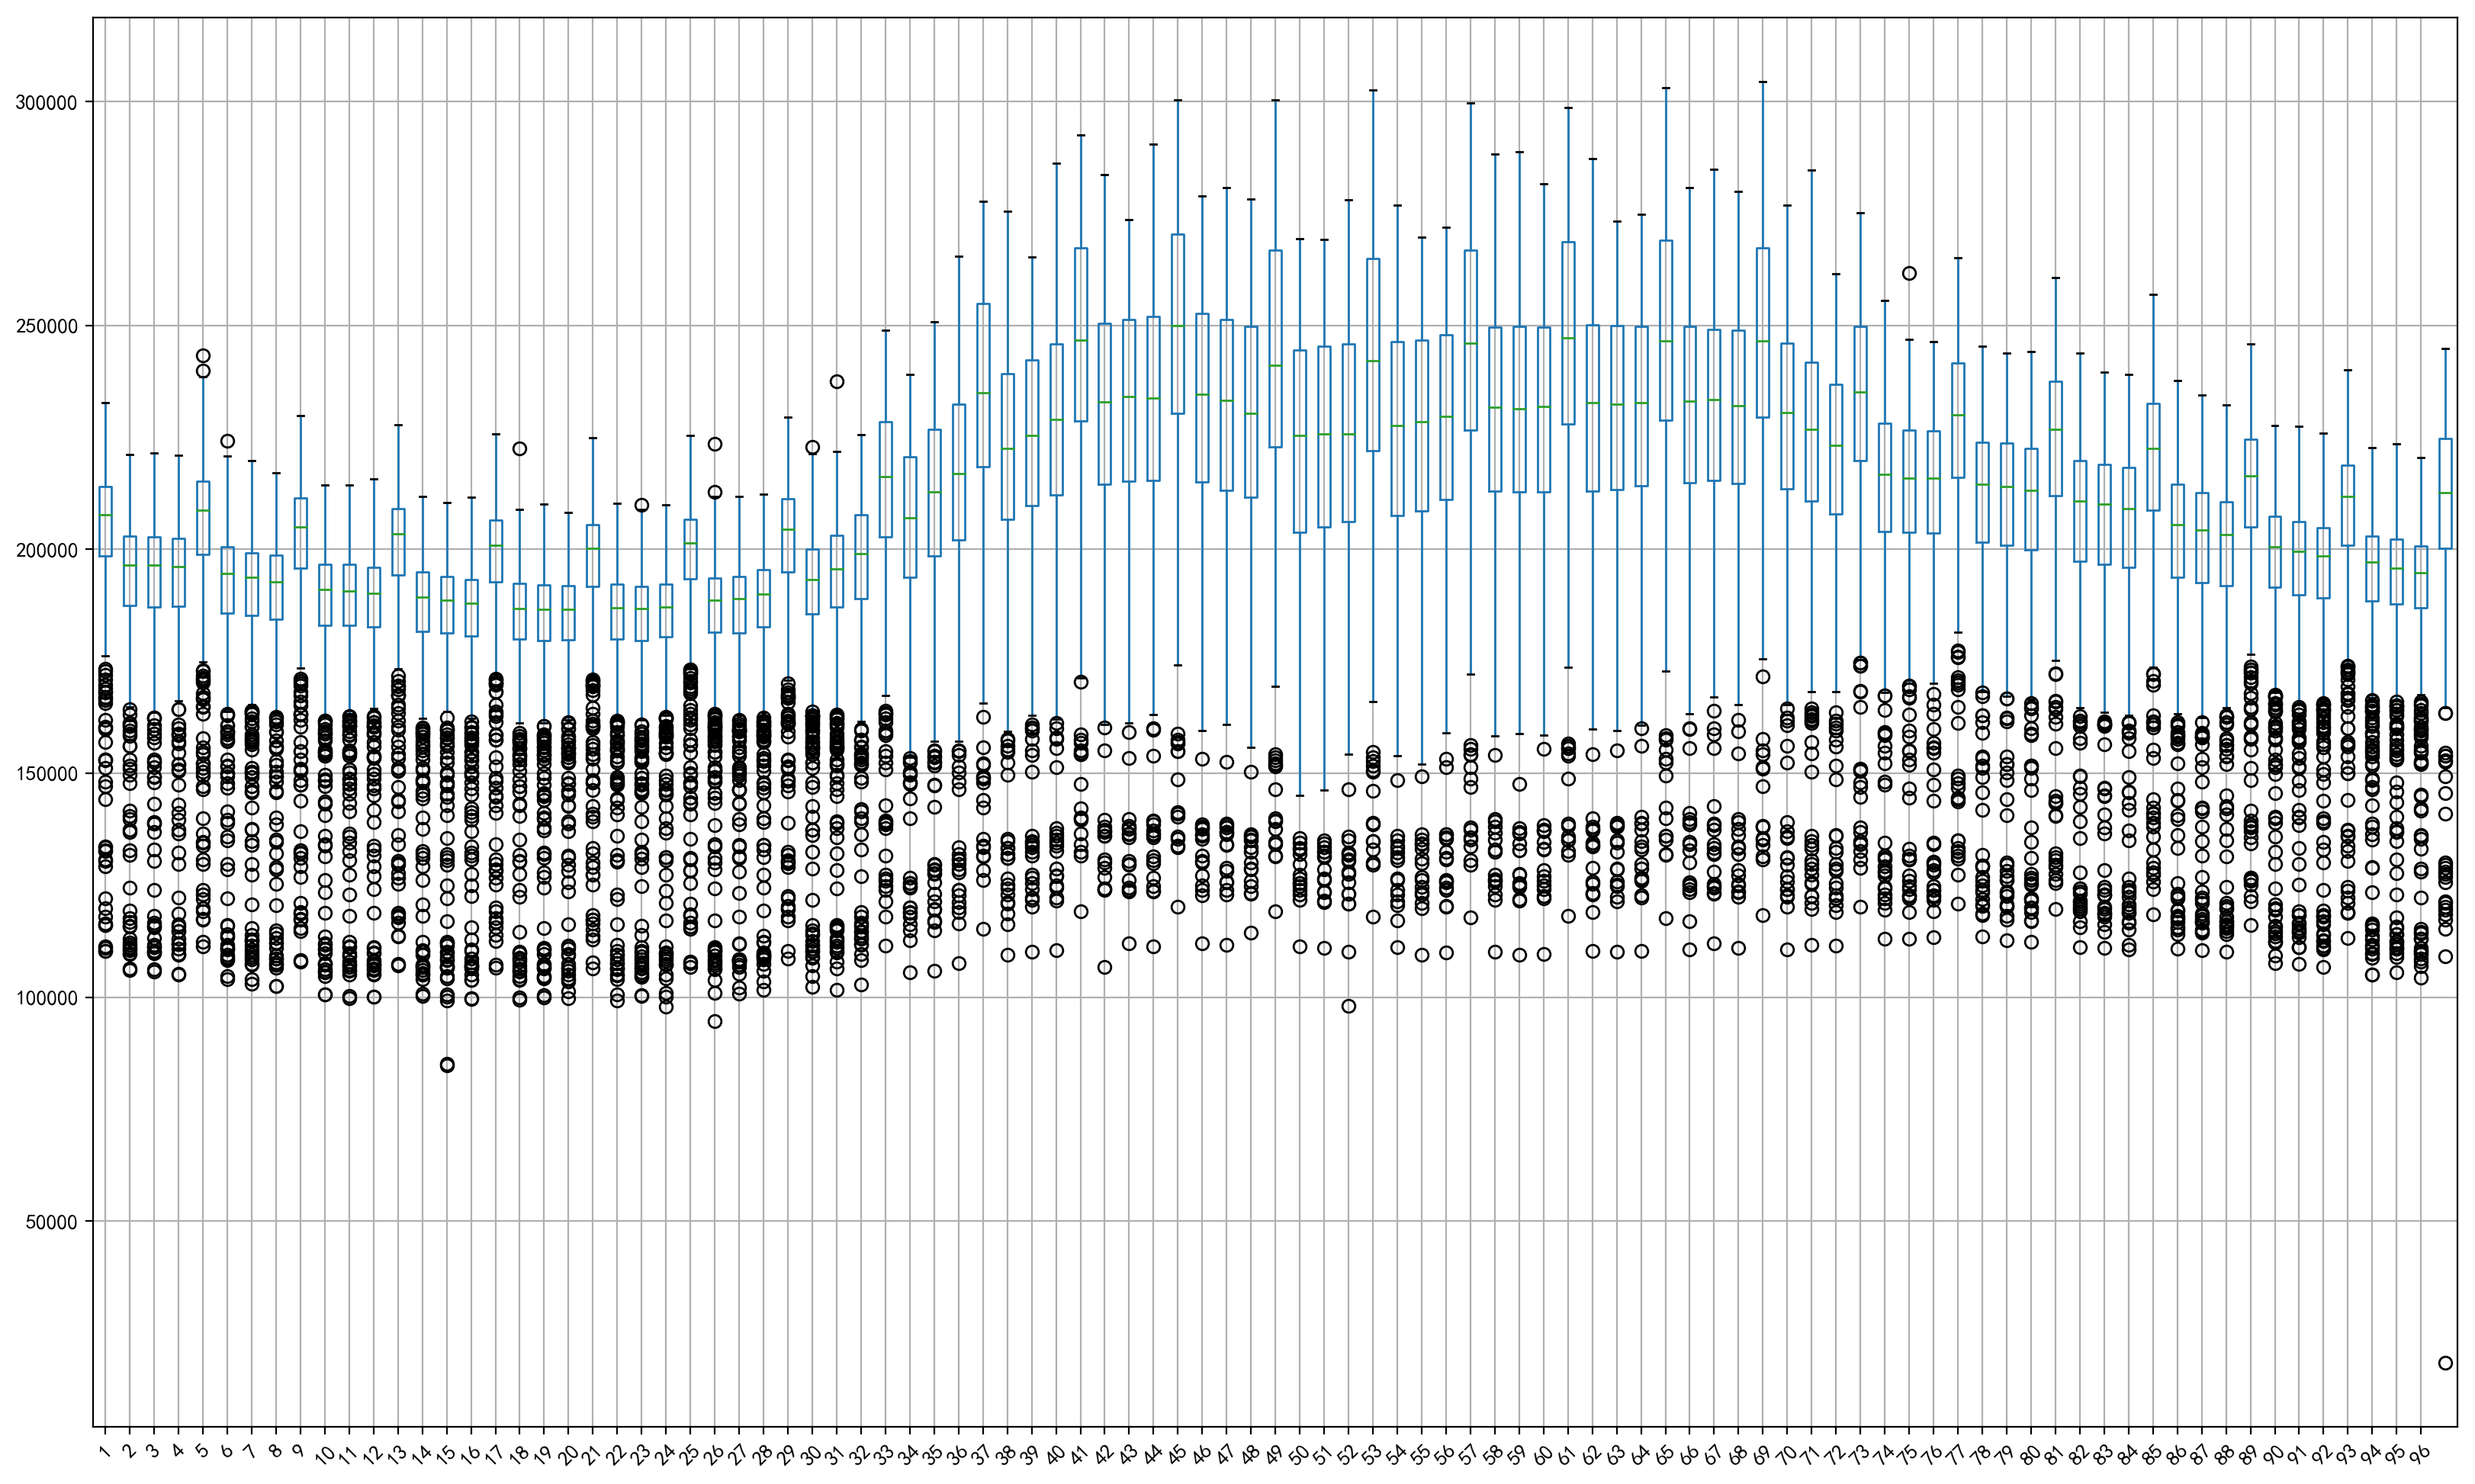

In [10]:
plt.figure(figsize=(20,12),dpi=200)

handle_data.boxplot()
xtick_list = range(1,97)
xlabel_list = range(1,97)

plt.xticks(xtick_list,xlabel_list,rotation=45,fontsize=10)    
plt.show()

可以观察到这个异常值情况明显改善，接下来使用数据平滑处理，为解决噪声干扰这里使用kalman filter进行数据平滑处理，消除噪声干扰

In [11]:
from pykalman import KalmanFilter

def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state

In [12]:
for i in range(96):
    values = handle_data.iloc[:,i].values
    handled_x = Kalman1D(values,0.1)
    handle_data.iloc[:,i] = handled_x
handle_data.head()

,节点0功率,节点1功率,节点2功率,节点3功率,节点4功率,节点5功率,节点6功率,节点7功率,节点8功率,节点9功率,...,节点87功率,节点88功率,节点89功率,节点90功率,节点91功率,节点92功率,节点93功率,节点94功率,节点95功率,平均功率
2018-08-16,212115.826763,201279.228739,198972.106659,199204.651170,210442.128194,197875.937173,197128.987999,195466.180270,208641.279980,196215.983000,...,199218.265523,215295.141940,199292.723008,199724.234757,199470.193028,212629.722054,198923.355963,198200.858173,195904.956912,222253.075403
2018-08-17,211444.527090,200646.894418,199163.582778,200204.447711,210201.629783,197255.807319,197270.805396,198181.114011,208254.288540,197586.187601,...,200202.429570,215287.723820,199920.361225,200222.572871,199644.485883,212797.315063,200630.009289,198650.814319,197205.757137,223346.411292
2018-08-18,211450.945005,201364.922916,199377.498876,199201.209362,209403.672055,197716.805483,195997.433089,198361.596362,209065.573440,197665.568403,...,199919.831687,215291.961719,199382.417566,199016.455456,197810.319122,211176.094336,200698.065004,199256.733685,196718.065500,218449.895951
2018-08-19,212294.821027,200385.093029,198488.939249,199434.151876,208916.931583,196776.307730,195777.682372,197185.182474,207339.931079,194670.329009,...,198992.232691,215312.093537,198990.315372,198568.969796,197037.482083,210522.986744,200434.904222,197962.501836,197984.420062,210888.285421
2018-08-20,212676.266974,200246.717970,198587.659572,198296.837467,208382.428893,196646.080307,194941.759927,195695.696261,206587.335797,194397.004723,...,201013.451485,215368.251092,199329.279052,199769.288032,198535.842127,211783.937497,199577.366162,199382.548022,198716.522687,223449.228417


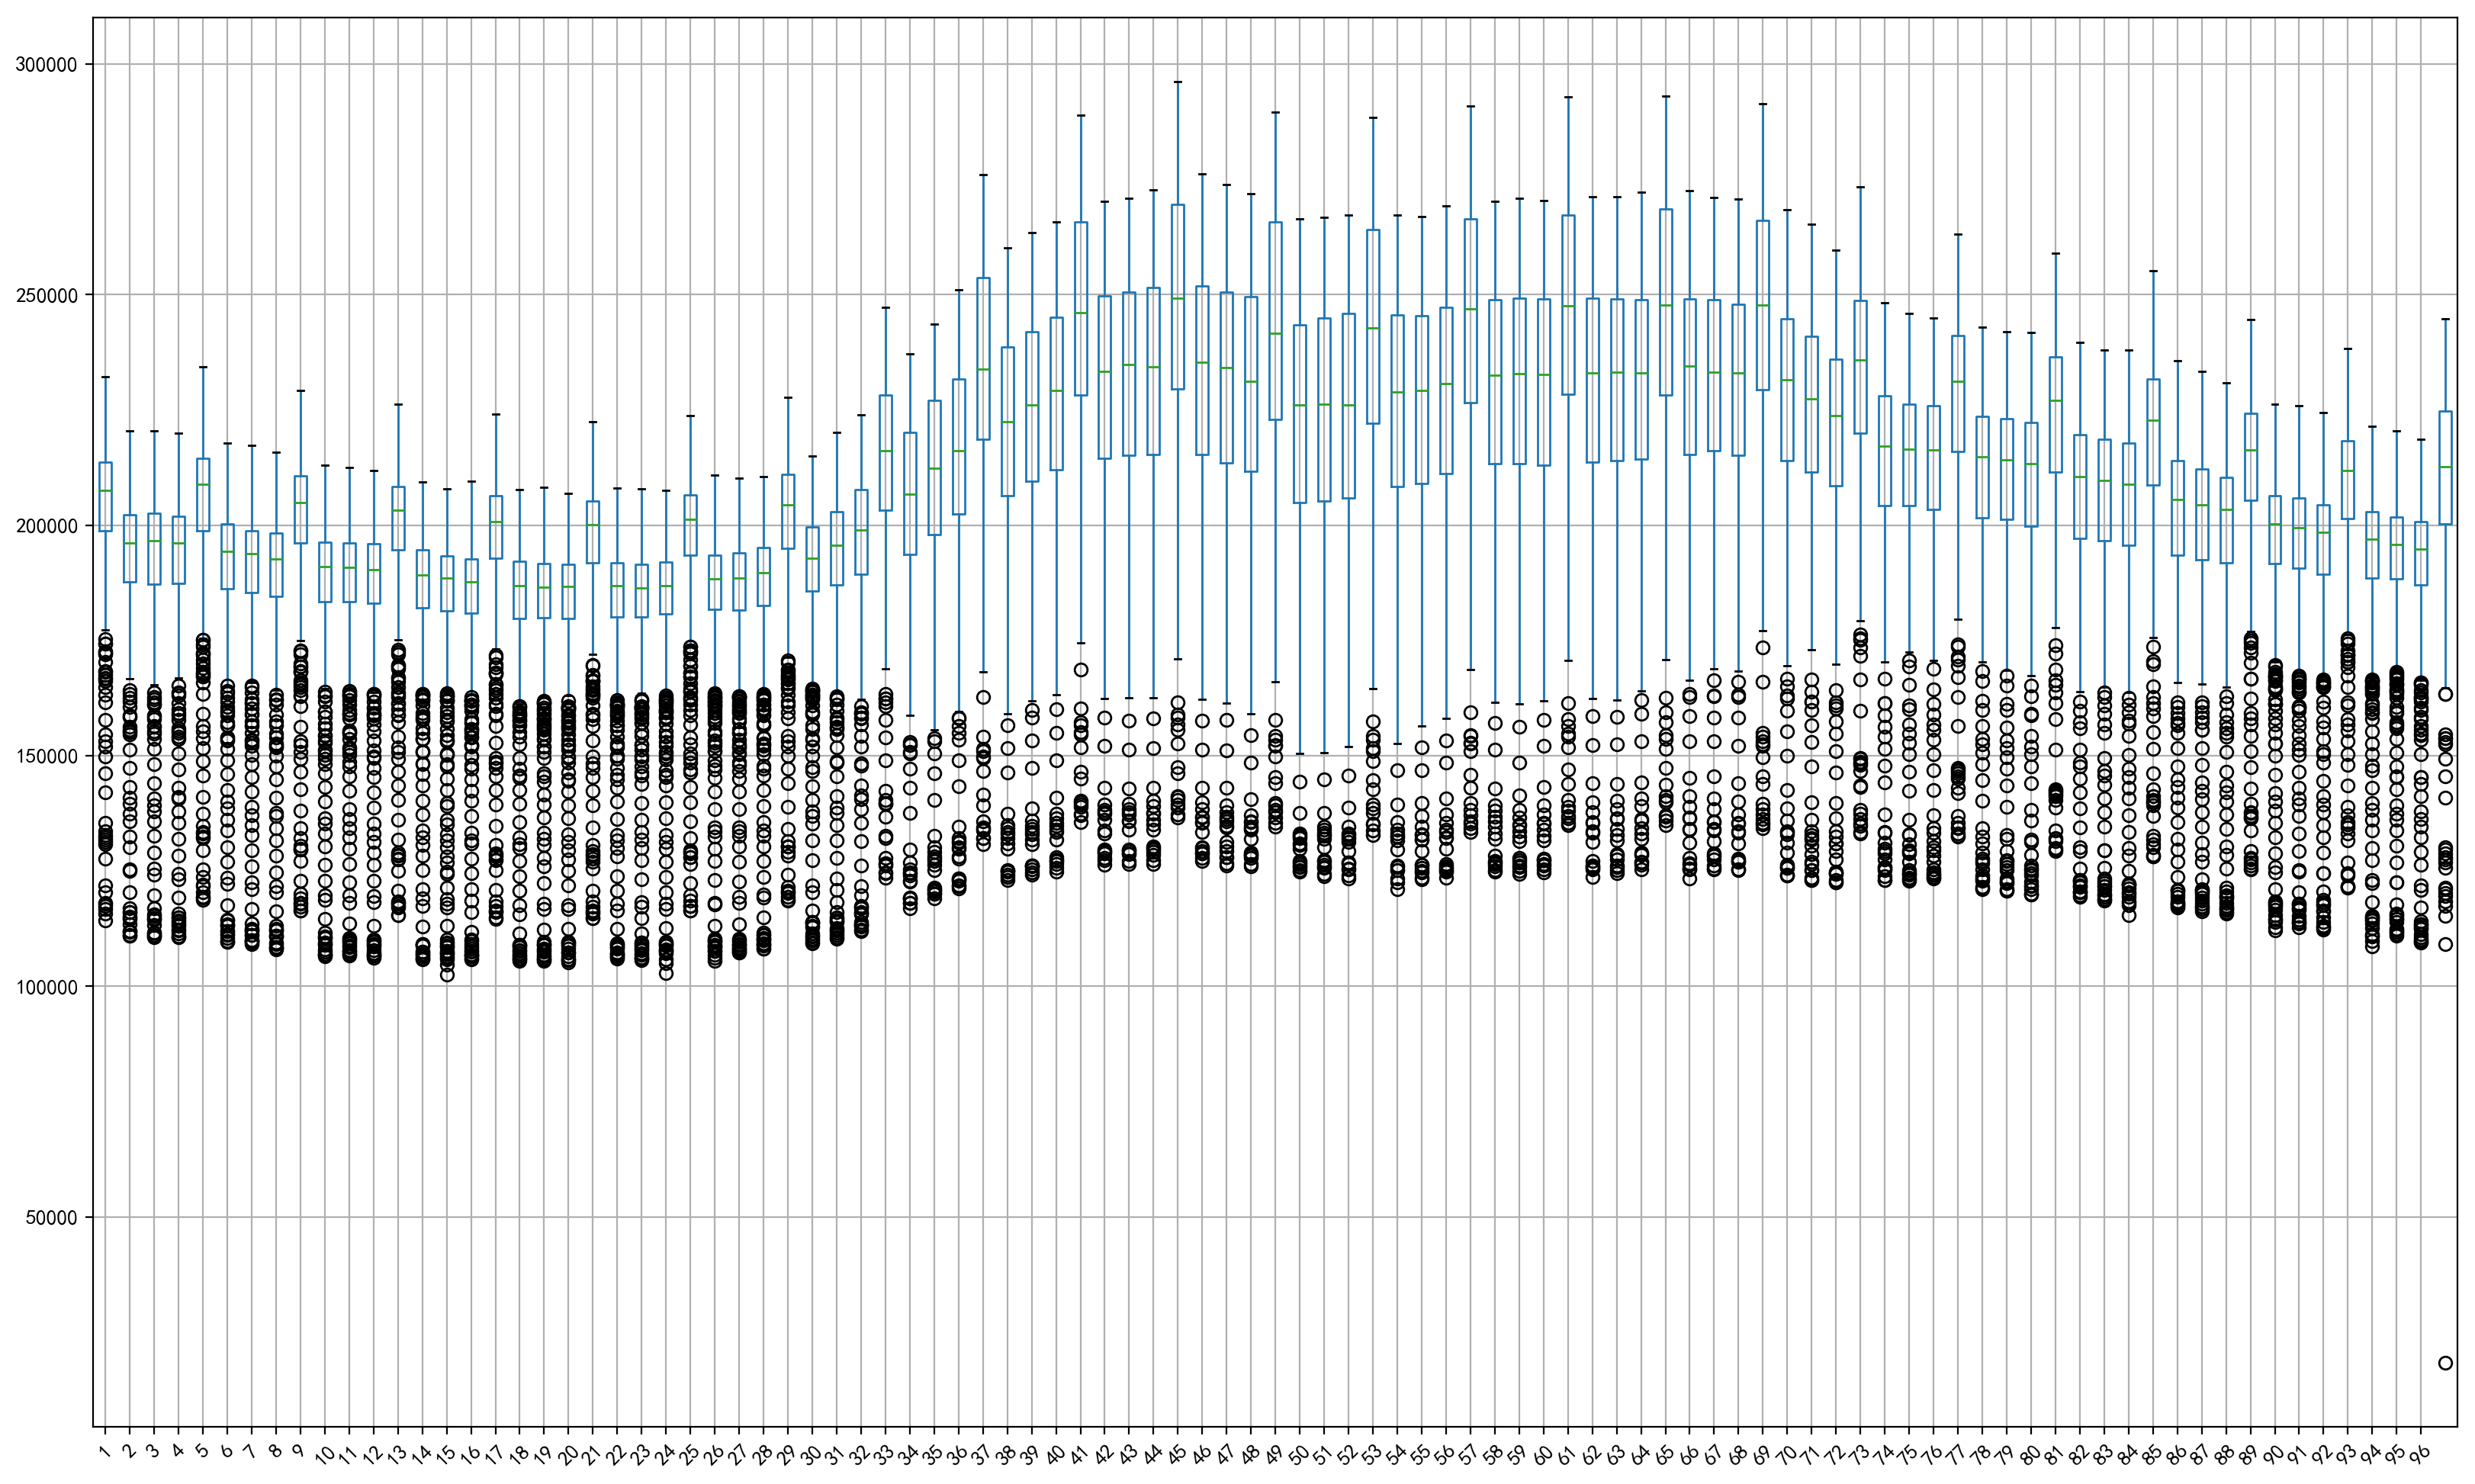

In [13]:
plt.figure(figsize=(20,12),dpi=200)

handle_data.boxplot()
xtick_list = range(1,97)
xlabel_list = range(1,97)

plt.xticks(xtick_list,xlabel_list,rotation=45,fontsize=10)    
plt.show()

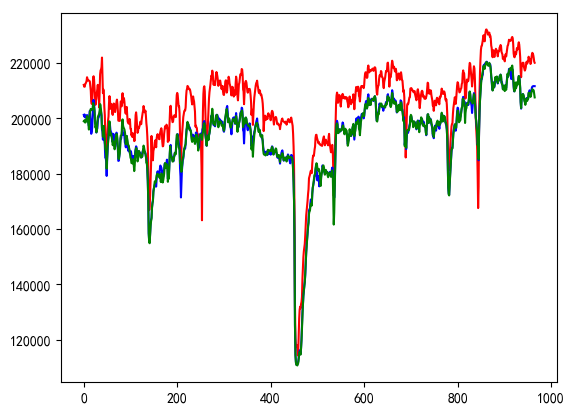

In [14]:
x1 = handle_data.iloc[:,0].values
x2 = handle_data.iloc[:,1].values
x3 = handle_data.iloc[:,2].values

plt.plot(x1,'r-')
plt.plot(x2,'b-')
plt.plot(x3,'g-')
plt.show()

In [15]:
bound_list = [datetime.datetime(2018,8,15),datetime.datetime(2019,1,1),datetime.datetime(2019,2,23),datetime.datetime(2020,1,1),
                datetime.datetime(2020,2,9),datetime.datetime(2021,1,1),datetime.datetime(2021,2,27),datetime.datetime(2022,1,1)]

for i in range(int(len(bound_list)/2)-1):
    list1 = np.array(data.index > bound_list[2*i+1])
    list2 = np.array(data.index < bound_list[2*(i+1)])
    tol_list = list1 & list2
    handle_data2 = pd.concat([handle_data2, data[tol_list]])
    handle_data = pd.concat([handle_data, data[tol_list]])
    exc_handled_data = pd.concat([exc_handled_data, data[tol_list]])
print(handle_data2.shape)
handle_data2.head()

(1112, 97)


,节点0功率,节点1功率,节点2功率,节点3功率,节点4功率,节点5功率,节点6功率,节点7功率,节点8功率,节点9功率,...,节点87功率,节点88功率,节点89功率,节点90功率,节点91功率,节点92功率,节点93功率,节点94功率,节点95功率,平均功率
2018-08-16,212451.4766,201595.3959,198876.3686,198704.7529,210562.3774,198186.0021,197058.0793,194108.7134,208834.7757,195530.8807,...,198726.1835,215298.8510,198978.9039,199475.0657,199383.0466,235528.3905,198070.0293,197975.8801,195254.5568,222253.075403
2018-08-17,210766.8095,199296.5316,199141.1428,202207.4826,210759.0891,196174.6793,198685.9951,200715.5654,207056.0122,198877.0114,...,201469.1915,217147.2767,201085.9431,201927.0284,201652.9455,214586.1288,202268.6069,198494.8511,198994.2490,223346.411292
2018-08-18,210613.4869,203062.7813,200479.9746,197965.0285,209092.4548,199118.3014,194943.8115,199718.4926,211602.5007,200740.1886,...,200564.8328,215276.0678,199236.5761,198257.8237,196748.9894,210207.9812,201029.2815,201156.8849,194964.0193,218449.895951
2018-08-19,212757.2511,199543.6382,197501.6593,200804.4088,208964.6938,195966.0374,196393.8541,197498.2548,206366.8840,191948.4139,...,196043.4149,206035.0892,198259.2495,196921.1659,194766.2850,208608.9284,195080.1897,195248.2238,191834.7059,210888.285421
2018-08-20,204752.5205,193591.6919,198174.9856,195901.7735,206143.7177,196580.9113,193168.5550,194902.8083,205326.3074,193219.9387,...,200637.7747,215193.9261,198215.4020,199868.5427,198628.3280,211884.5114,197327.2822,200000.8831,199414.7702,223449.228417


In [16]:
handle_data.drop(columns=['平均功率'],inplace=True)
handle_data_val = handle_data.values
mean_list = np.mean(handle_data_val,axis=1)
handle_data['平均功率'] = mean_list
print(handle_data.shape)
handle_data.head()

(1112, 97)


,节点0功率,节点1功率,节点2功率,节点3功率,节点4功率,节点5功率,节点6功率,节点7功率,节点8功率,节点9功率,...,节点87功率,节点88功率,节点89功率,节点90功率,节点91功率,节点92功率,节点93功率,节点94功率,节点95功率,平均功率
2018-08-16,212115.826763,201279.228739,198972.106659,199204.651170,210442.128194,197875.937173,197128.987999,195466.180270,208641.279980,196215.983000,...,199218.265523,215295.141940,199292.723008,199724.234757,199470.193028,212629.722054,198923.355963,198200.858173,195904.956912,221961.344097
2018-08-17,211444.527090,200646.894418,199163.582778,200204.447711,210201.629783,197255.807319,197270.805396,198181.114011,208254.288540,197586.187601,...,200202.429570,215287.723820,199920.361225,200222.572871,199644.485883,212797.315063,200630.009289,198650.814319,197205.757137,221699.898553
2018-08-18,211450.945005,201364.922916,199377.498876,199201.209362,209403.672055,197716.805483,195997.433089,198361.596362,209065.573440,197665.568403,...,199919.831687,215291.961719,199382.417566,199016.455456,197810.319122,211176.094336,200698.065004,199256.733685,196718.065500,220574.375223
2018-08-19,212294.821027,200385.093029,198488.939249,199434.151876,208916.931583,196776.307730,195777.682372,197185.182474,207339.931079,194670.329009,...,198992.232691,215312.093537,198990.315372,198568.969796,197037.482083,210522.986744,200434.904222,197962.501836,197984.420062,220654.058405
2018-08-20,212676.266974,200246.717970,198587.659572,198296.837467,208382.428893,196646.080307,194941.759927,195695.696261,206587.335797,194397.004723,...,201013.451485,215368.251092,199329.279052,199769.288032,198535.842127,211783.937497,199577.366162,199382.548022,198716.522687,222810.818082


In [17]:
print(exc_handled_data.shape)

(1112, 97)


In [18]:
handle_data.sort_index(axis=0, ascending=True,inplace=True)
handle_data2.sort_index(axis=0, ascending=True, inplace=True)
exc_handled_data.sort_index(axis=0, ascending=True, inplace=True)

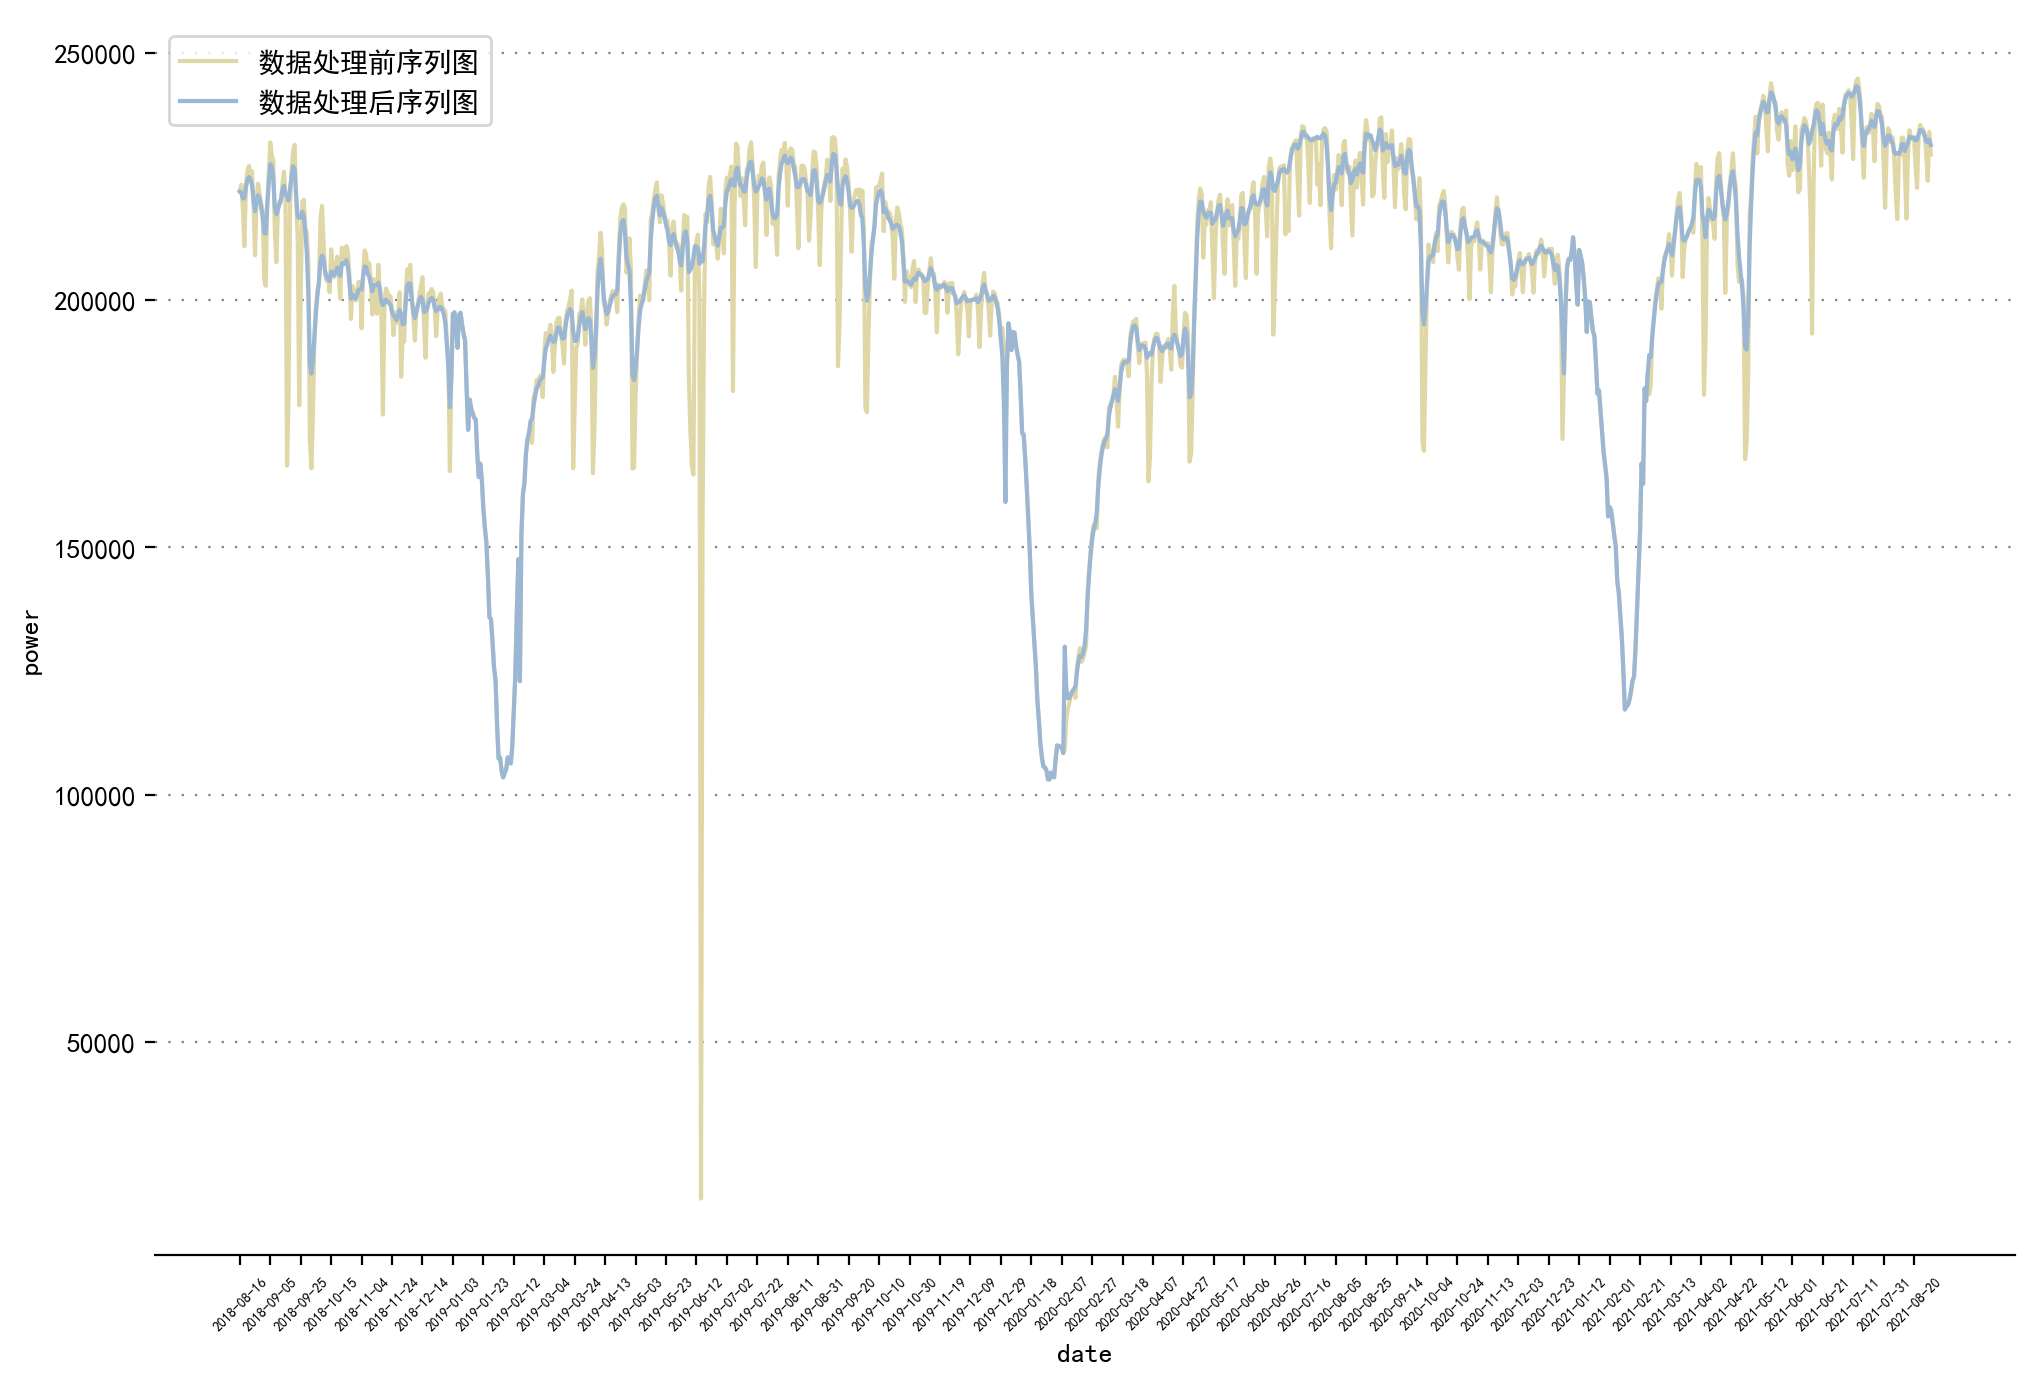

In [19]:
plt.figure(figsize=(12,8),dpi=200)
ax = plt.subplot()
x = np.arange(handle_data.shape[0])

ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))

ax.plot(x, handle_data2['平均功率'].values, label='数据处理前序列图', color='#e0d7a7') 
ax.plot(x, handle_data['平均功率'].values, label='数据处理后序列图',color='#9bb7d4')

for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)

xtick_list = np.linspace(0,1100,56).tolist()
xlabel_list = [handle_data.index[int(xtick_list[i])].date() for i in range(56)]


plt.xticks(xtick_list,xlabel_list,rotation=45,fontsize=5)    
plt.xlabel('date')
plt.ylabel('power')
plt.legend()

plt.show()

In [21]:
exc_handled_data.to_excel('异常值处理后的数据.xlsx')
handle_data.to_excel('数据平滑处理后的数据.xlsx')